# Deep Agent의 TODO 리스트 관리 및 툴 구현

이 튜토리얼에서는 LangChain과 LangGraph를 활용하여 Deep Agent의 상태 관리와 TODO 리스트 기반의 작업 플로우를 설계하는 방법을 다룹니다. 

복잡한 장기 작업을 효과적으로 관리하기 위해 TODO 리스트를 활용하는 전략과, 이를 위한 커스텀 state 및 툴(write_todos, read_todos) 구현 과정을 단계별로 설명합니다. 또한, 실제 에이전트 그래프를 구축하고, TODO 리스트를 통한 작업 추적 및 컨텍스트 유지 방법을 실습합니다.

**🏆 주로 다루는 내용**
1. TODO 리스트 기반 에이전트 플래닝  
   - 장기 작업 수행 시 TODO 리스트를 활용하여 에이전트가 목표를 잊지 않고 집중할 수 있도록 하는 방법을 설명합니다.
2. DeepAgentState 설계 및 상태 관리  
   - messages, todos, files 등 커스텀 state 구조와 reducer 함수(file_reducer)를 통한 상태 병합 및 관리 방법을 다룹니다.
3. TODO 관리 툴 구현 (write_todos, read_todos)  
   - 에이전트가 TODO 리스트를 생성, 갱신, 조회할 수 있도록 하는 툴의 구현 방식과 사용 예시를 제공합니다.
4. LangChain 기반 에이전트 그래프 구축  
   - create_agent를 활용하여 TODO 리스트와 툴을 통합한 에이전트 그래프를 설계하고, 실제 동작 과정을 시각화합니다.
5. 에이전트 실습 및 TODO 리스트 활용  
   - 사용자 요청에 따라 TODO 리스트를 생성하고, 웹 검색 결과를 활용하여 작업을 수행하는 전체 플로우를 실습합니다.

In [ ]:
from dotenv import load_dotenv
from langchain_teddynote import logging

# 환경 변수 로드
load_dotenv(override=True)
# 추적을 위한 프로젝트 이름 설정
logging.langsmith("Deep-Agent-Tutorial")

LangSmith 추적을 시작합니다.
[프로젝트명]
LangChain-V1-Tutorial


## TODO 리스트를 활용한 에이전트 플래닝

복잡하고 장기적인 작업을 수행하는 에이전트는 `TODO list`를 핵심적인 내비게이션 도구로 활용합니다. 

대표적으로 Claude Code에서는 [plan mode](https://www.anthropic.com/engineering/claude-code-best-practices)를 통해 작업 실행 전 구조화된 TODO 리스트를 생성하며, [Claude Code prompt](https://cchistory.mariozechner.at/)를 기반으로 한 `TodoWrite` 툴을 사용합니다. 

각 TODO 항목은 `content`(구체적이고 간결한 작업 설명)와 `status`(pending, in_progress, completed) 두 가지 주요 속성으로 구성됩니다.

실제 장기 작업에서는 평균적으로 50회 이상의 툴 호출이 발생하며, 이로 인해 컨텍스트 윈도우가 커질수록 **context rot**([참고](https://research.trychroma.com/context-rot)) 현상이 발생할 수 있습니다. 이는 에이전트가 대화가 길어지거나 복잡한 작업을 수행할 때 초기에 설정한 목표를 잊거나, 논점에서 벗어날 위험이 커진다는 의미입니다.

이러한 문제를 해결하기 위해, 에이전트는 TODO 리스트를 지속적으로 갱신하고 재작성합니다. 예를 들어, Manus와 같은 시스템에서는 작업 컨텍스트의 마지막에 TODO 리스트를 반복적으로 정리함으로써, 에이전트가 항상 현재 목표에 집중할 수 있도록 돕고 **mission drift**를 방지합니다. 자세한 내용은 [Context Engineering for AI Agents: Lessons from Building Manus](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus)에서 확인할 수 있습니다.

> **TIP**  
> TODO 리스트를 효과적으로 관리하면, 에이전트가 장기 작업에서도 목표를 잊지 않고 일관성 있게 작업을 수행할 수 있습니다.

---

**참고:**  
- [Claude Code plan mode](https://www.anthropic.com/engineering/claude-code-best-practices)  
- [Claude Code prompt 예시](https://cchistory.mariozechner.at/)  
- [Context rot 개념](https://research.trychroma.com/context-rot)  
- [Manus의 컨텍스트 엔지니어링 사례](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus)

### State

이전 단계와 마찬가지로, 이번에도 커스텀 state를 적용한 `create_agent`를 사용합니다.

State 객체는 워크플로우의 각 단계에서 컨텍스트를 저장하고 전달하는 핵심 역할을 합니다. 이 객체는 그래프의 스키마와, state 업데이트 방식을 정의하는 reducer 함수들로 구성됩니다.

DeepAgent의 state 구조에는 세 가지 주요 요소가 포함되어 있습니다: **`messages`**, **`todo`**, **`files`**.

- **`messages`**  
  - `messages`는 `AgentState`로부터 상속받은 메시지 리스트입니다.
  - 새로운 메시지는 `add_messages` reducer를 통해 리스트의 끝에 추가됩니다.

- **`todo`**  
  - `todo`는 여러 개의 `Todo` 작업으로 이루어진 리스트입니다. 각 작업은 `content`(구체적이고 간결한 작업 설명)와 `status`(pending, in_progress, completed) 속성을 가집니다.
  - 별도의 커스텀 reducer는 정의되어 있지 않으므로, 업데이트 시 리스트 전체가 덮어써집니다.

- **`files`**  
  - `files`는 state 내에 포함된 가상 파일 시스템입니다. 이 부분은 다음 단계에서 자세히 다룹니다.

이처럼 커스텀 state 구조를 활용하면, 에이전트가 장기 작업을 수행할 때 각종 메시지, TODO 리스트, 파일 등 다양한 컨텍스트 정보를 효과적으로 관리할 수 있습니다.

In [2]:
from typing import Annotated, Literal, NotRequired
from typing_extensions import TypedDict

# from langgraph.prebuilt.chat_agent_executor import AgentState
from langchain.agents import AgentState  # updated in 1.0


# 복잡한 작업 플로우의 진행 상황 추적을 위한 TODO 항목 구조 정의
class Todo(TypedDict):
    """A structured task item for tracking progress through complex workflows.

    Attributes:
        content: Short, specific description of the task
        status: Current state - pending, in_progress, or completed
    """

    content: str
    status: Literal["pending", "in_progress", "completed"]


# 두 파일 딕셔너리 병합, 오른쪽 값이 우선 적용되는 가상 파일 시스템 업데이트용 reducer 함수
def file_reducer(left, right):
    """Merge two file dictionaries, with right side taking precedence.

    Used as a reducer function for the files field in agent state,
    allowing incremental updates to the virtual file system.

    Args:
        left: Left side dictionary (existing files)
        right: Right side dictionary (new/updated files)

    Returns:
        Merged dictionary with right values overriding left values
    """
    if left is None:
        return right
    elif right is None:
        return left
    else:
        return {**left, **right}


# LangGraph AgentState 상속, TODO 리스트와 가상 파일 시스템 포함한 확장 state 구조 정의
class DeepAgentState(AgentState):
    """Extended agent state that includes task tracking and virtual file system.

    Inherits from LangGraph's AgentState and adds:
    - todos: List of Todo items for task planning and progress tracking
    - files: Virtual file system stored as dict mapping filenames to content
    """

    # 작업 플래닝 및 진행 상황 추적을 위한 Todo 리스트 필드
    todos: NotRequired[list[Todo]]
    # 파일명과 내용 매핑, file_reducer로 병합되는 가상 파일 시스템 필드
    files: Annotated[NotRequired[dict[str, str]], file_reducer]

#### Todo 관리 툴 설명

앞서 설명한 바와 같이, 장기 작업을 수행하는 에이전트는 `todo list`를 활용하여 목표에 집중할 수 있습니다. 이를 위해 `write_todo`와 `read_todo`와 같은 **todo 관리 툴**이 제공됩니다. 아래의 툴 설명은 LLM에게 언제 `todo list`를 사용해야 하는지, 리스트에 어떤 정보가 포함되는지, 그리고 어떻게 읽고 갱신하는지에 대한 지침을 제공합니다.

특히, 각 작업은 개별적으로 리스트에 포함되지만, 리스트 전체를 한 번에 재작성하여 업데이트합니다. 이러한 방식은 LLM이 작업을 진행하면서 필요한 경우 전체 작업 목록을 재구성할 수 있도록 하여, 보다 유연하게 목표를 관리할 수 있게 합니다.

**주요 포인트**
- `todo list`는 에이전트가 장기 작업의 목표를 잊지 않고 일관성 있게 진행할 수 있도록 돕는 핵심 도구입니다.
- `write_todo` 툴을 통해 전체 리스트를 재작성하며, 진행 상황에 따라 작업 항목을 추가하거나 수정할 수 있습니다.
- `read_todo` 툴을 사용하면 현재의 작업 목록을 조회할 수 있습니다.
- 이러한 툴 설명은 LLM에게 명확한 사용 시점과 방법을 안내하여, 에이전트의 작업 플로우를 효과적으로 관리할 수 있도록 지원합니다.

In [3]:
# 프롬프트 출력 함수 show_prompt 사용 목적, LLM 프롬프트 예시 시각화
from utils import show_prompt

from deep_agents_from_scratch.prompts import WRITE_TODOS_DESCRIPTION

# WRITE_TODOS_DESCRIPTION 프롬프트 내용을 시각적으로 출력, LLM 툴 설명 확인 용도
show_prompt(WRITE_TODOS_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  Create and manage structured task lists for tracking progress through complex workflows.                       │
│                                                                                                                 │
│  ## When to Use                                                                                                 │
│  - Multi-step or non-trivial tasks requiring coordination                                                       │
│  - When user provides multiple tasks or explicitly requests todo list                                           │
│  - Avoid for single, trivial actions unless directed otherwise                                                  │
│                                                                                                                 │
│  ## Structure                                                                                                   │
│  - Maintain one list containing multiple todo objects (content, status, id)                                     │
│  - Use clear, actionable content descriptions                                                                   │
│  - Status must be: pending, in_progress, or completed                                                           │
│                                                                                                                 │
│  ## Best Practices                                                                                              │
│  - Only one in_progress task at a time                                                                          │
│  - Mark completed immediately when task is fully done                                                           │
│  - Always send the full updated list when making changes                                                        │
│  - Prune irrelevant items to keep list focused                                                                  │
│                                                                                                                 │
│  ## Progress Updates                                                                                            │
│  - Call TodoWrite again to change task status or edit content                                                   │
│  - Reflect real-time progress; don't batch completions                                                          │
│  - If blocked, keep in_progress and add new task describing blocker                                             │
│                                                                                                                 │
│  ## Parameters                                                                                                  │
│  - todos: List of TODO items with content and status fields                                                     │
│                                                                                                                 │
│  ## Returns                                                                                                     │
│  Updates agent state with new todo list.                                                                        │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

#### Write 및 Read ToDo 툴 구현

이제 에이전트의 작업 플로우에서 핵심 역할을 하는 `write_todos`와 `read_todos` 툴을 직접 구현합니다.  
`write_todos` 툴은 LLM이 전달한 todo 리스트를 받아 state에 저장하며, 기존 리스트는 새로 입력된 내용으로 덮어쓰기됩니다. 저장이 완료되면, 작성된 리스트를 포함한 `ToolMessage`를 반환합니다. 이 과정에서 todo 리스트 정보는 대화 기록(`messages`)에 남아, 이후 LLM이 작업 맥락을 유지하는 데 활용됩니다.

반면, `read_todos` 툴은 현재 state에 저장된 todo 리스트를 읽어와 `ToolMessage`로 반환합니다. 이를 통해 LLM은 최신 작업 목록을 다시 확인하거나, 컨텍스트를 갱신할 수 있습니다.

이 두 툴은 이전 단계에서 다룬 주요 기능들을 활용합니다.

- `InjectedState`를 사용하여 툴이 그래프의 state에 접근할 수 있도록 합니다.
- `Command`를 통해 state 값을 효과적으로 업데이트합니다.

이처럼 `write_todos`와 `read_todos` 툴을 활용하면, 에이전트가 장기 작업을 수행할 때 목표와 진행 상황을 체계적으로 관리할 수 있습니다.  
앞서 설명한 커스텀 state 구조와 연계하여, 에이전트의 작업 플래닝 및 컨텍스트 유지가 한층 더 효율적으로 이루어집니다.

In [4]:
from typing import Annotated

from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command

from deep_agents_from_scratch.prompts import WRITE_TODOS_DESCRIPTION
from deep_agents_from_scratch.state import DeepAgentState, Todo


# write_todos 툴 정의, LLM이 전달한 TODO 리스트를 state에 저장 및 메시지 기록
@tool(description=WRITE_TODOS_DESCRIPTION, parse_docstring=True)
def write_todos(
    todos: list[Todo], tool_call_id: Annotated[str, InjectedToolCallId]
) -> Command:
    """Create or update the agent's TODO list for task planning and tracking.

    Args:
        todos: List of Todo items with content and status
        tool_call_id: Tool call identifier for message response

    Returns:
        Command to update agent state with new TODO list
    """
    # TODO 리스트와 메시지 업데이트를 위한 Command 객체 반환
    return Command(
        update={
            "todos": todos,
            "messages": [
                ToolMessage(f"Updated todo list to {todos}", tool_call_id=tool_call_id)
            ],
        }
    )


# read_todos 툴 정의, 현재 state의 TODO 리스트를 읽어 포맷된 문자열로 반환
@tool(parse_docstring=True)
def read_todos(
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
) -> str:
    """Read the current TODO list from the agent state.

    This tool allows the agent to retrieve and review the current TODO list
    to stay focused on remaining tasks and track progress through complex workflows.

    Args:
        state: Injected agent state containing the current TODO list
        tool_call_id: Injected tool call identifier for message tracking

    Returns:
        Formatted string representation of the current TODO list
    """
    # state에서 todos 리스트 추출, 없으면 빈 리스트 반환
    todos = state.get("todos", [])
    if not todos:
        # TODO 리스트가 비어 있을 때 안내 메시지 반환
        return "No todos currently in the list."

    # 현재 TODO 리스트를 번호, 이모지, 상태와 함께 포맷팅하여 문자열로 생성
    result = "Current TODO List:\n"
    for i, todo in enumerate(todos, 1):
        status_emoji = {"pending": "⏳", "in_progress": "🔄", "completed": "✅"}
        emoji = status_emoji.get(todo["status"], "❓")
        result += f"{i}. {emoji} {todo['content']} ({todo['status']})\n"

    # 최종 포맷된 TODO 리스트 문자열 반환
    return result.strip()

### Graph

이전 단계에서와 마찬가지로, 이번에도 `create_agent`를 활용하여 에이전트를 구축합니다. 이번에는 에이전트가 `todo list`를 적극적으로 활용하도록 설계하는 데 중점을 둡니다. 특히, [Manus](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus)에서 제안한 방식처럼 각 작업이 끝날 때마다 todo 리스트를 다시 확인하고 낭독(recitation)하는 전략을 적용합니다. 앞서 구현한 todo 관리 툴을 연계하여, 에이전트가 장기 작업에서도 목표를 잊지 않고 일관성 있게 작업을 이어갈 수 있도록 합니다.

In [5]:
from deep_agents_from_scratch.prompts import TODO_USAGE_INSTRUCTIONS

# TODO 리스트 사용 지침 프롬프트 시각화, 에이전트 툴 활용 시 참고 목적
show_prompt(TODO_USAGE_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  Based upon the user's request:                                                                                 │
│  1. Use the write_todos tool to create TODO at the start of a user request, per the tool description.           │
│  2. After you accomplish a TODO, use the read_todos to read the TODOs in order to remind yourself of the plan.  │
│  3. Reflect on what you've done and the TODO.                                                                   │
│  4. Mark you task as completed, and proceed to the next TODO.                                                   │
│  5. Continue this process until you have completed all TODOs.                                                   │
│                                                                                                                 │
│  IMPORTANT: Always create a research plan of TODOs and conduct research following the above guidelines for ANY  │
│  user request.                                                                                                  │
│  IMPORTANT: Aim to batch research tasks into a *single TODO* in order to minimize the number of TODOs you have  │
│  to keep track of.                                                                                              │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

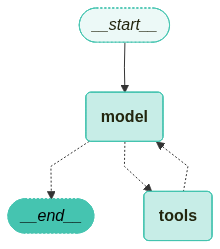

In [6]:
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool

# from langgraph.prebuilt import create_react_agent
from langchain.agents import create_agent
from utils import format_messages

from deep_agents_from_scratch.prompts import TODO_USAGE_INSTRUCTIONS
from deep_agents_from_scratch.state import DeepAgentState
from deep_agents_from_scratch.todo_tools import read_todos, write_todos

from langchain_teddynote.graphs import visualize_graph

# 웹 검색 결과 모킹, 실제 검색 대신 고정된 결과 반환
search_result = """The Model Context Protocol (MCP) is an open standard protocol developed
by Anthropic to enable seamless integration between AI models and external systems like
tools, databases, and other services. It acts as a standardized communication layer,
allowing AI models to access and utilize data from various sources in a consistent and
efficient manner. Essentially, MCP simplifies the process of connecting AI assistants
to external services by providing a unified language for data exchange. """


# 웹 검색 툴 모킹, 실제 검색 대신 고정된 결과 반환
@tool(parse_docstring=True)
def web_search(
    query: str,
):
    """Search the web for information on a specific topic.

    This tool performs web searches and returns relevant results
    for the given query. Use this when you need to gather information from
    the internet about any topic.

    Args:
        query: The search query string. Be specific and clear about what
               information you're looking for.

    Returns:
        Search results from search engine.

    Example:
        web_search("machine learning applications in healthcare")
    """
    return search_result


# LLM 모델 초기화, Claude Sonnet 4 버전 및 온도 0.0 설정
model = init_chat_model(model="openai:gpt-4.1", temperature=0.0)
# 에이전트에 사용할 툴 리스트 정의, TODO 관리 및 웹 검색 포함
tools = [write_todos, web_search, read_todos]

# 단일 웹 검색 호출만 허용하는 간단한 리서치 지침 문자열
SIMPLE_RESEARCH_INSTRUCTIONS = """IMPORTANT: Just make a single call to the web_search tool and use the result provided by the tool to answer the user's question. Answer in Korean."""

# create_agent 함수로 에이전트 생성, 시스템 프롬프트에 TODO 사용 지침 및 리서치 지침 포함
agent = create_agent(
    model,
    tools,
    system_prompt=TODO_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + SIMPLE_RESEARCH_INSTRUCTIONS,
    state_schema=DeepAgentState,
)

# 에이전트 그래프 시각화, Mermaid PNG 포맷으로 출력
visualize_graph(agent)

그래프의 시작 단계에서는 state에 `todos`가 없는 상태에서 사용자로부터 리서치 요청을 받도록 설계합니다.  
이렇게 초기화하면 에이전트가 작업을 시작할 때 아직 할 일이 등록되어 있지 않으므로, 첫 번째 사용자 요청을 기반으로 `todo list`를 생성하고 관리하는 전체 플로우를 자연스럽게 실습할 수 있습니다.  
이 과정은 앞서 설명한 커스텀 state 구조와 `write_todos`, `read_todos` 툴의 활용법을 실제로 적용하는 데 중요한 역할을 합니다.  
따라서, 에이전트가 장기적인 목표를 설정하고, 각 단계별로 진행 상황을 추적하는 방법을 명확하게 이해할 수 있습니다.

In [7]:
from langchain_teddynote.messages import invoke_graph

inputs = {
    "messages": [
        {
            "role": "user",
            "content": "Model Context Protocol (MCP) 에 대해서 짧고 간결하게 설명해 주세요.",
        }
    ]
}

invoke_graph(agent, inputs)


🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  write_todos (call_BApBFSmlZSPz1P8NqN0AMelE)
 Call ID: call_BApBFSmlZSPz1P8NqN0AMelE
  Args:
    todos: [{'content': 'Model Context Protocol (MCP)에 대해 최신 정보를 조사하고, 짧고 간결하게 설명 작성하기', 'status': 'pending'}]

🔄 Node: tools 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{'content': 'Model Context Protocol (MCP)에 대해 최신 정보를 조사하고, 짧고 간결하게 설명 작성하기', 'status': 'pending'}
================================= Tool Message =================================
Name: write_todos

Updated todo list to [{'content': 'Model Context Protocol (MCP)에 대해 최신 정보를 조사하고, 짧고 간결하게 설명 작성하기', 'status': 'pending'}]

🔄 Node: model 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  write_todos (call_WotFHg5rZZ1Bskw0QoRC10h1)
 Call ID: call_WotFHg5rZZ1Bskw0QoRC10h1


**실행 결과 추적**

에이전트의 실행 흐름과 내부 상태 변화를 시각적으로 확인하고 싶다면, 아래 LangChain Smith 플랫폼의 Trace 링크를 참고하시기 바랍니다.

- [LangChain Smith Trace](https://smith.langchain.com/public/7e771e79-8996-4833-8242-2b3559c2c1d7/r)

이 링크에서는 실제 에이전트가 TODO 리스트를 생성하고, 웹 검색 툴을 활용하여 사용자 요청을 처리하는 전체 과정을 단계별로 확인할 수 있습니다. 각 단계별로 state의 변화와 툴 호출 내역이 기록되어 있으므로, 복잡한 작업 플로우에서 에이전트가 어떻게 목표를 관리하고 컨텍스트를 유지하는지 실습 결과를 직접 검토할 수 있습니다.

실제 에이전트의 동작을 분석하거나, 커스텀 state 및 TODO 관리 툴의 적용 효과를 확인하고 싶을 때 유용하게 활용할 수 있습니다.